In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import forward_backward as fb
np.random.seed(12345)

In [432]:
def generating_states(pi,A,Ntimes):
    
    Q = np.empty(Ntimes).astype('int')

    Nstates=np.shape(A)[0]
    
    states = np.zeros((Nstates, Ntimes))
    
    Q[0]=np.random.choice(Nstates,1,p=pi)[0]
    
    states[int(Q[0]),0]=1
    
    for t in range(1, Ntimes):
        
        Q[t]=np.random.choice(Nstates,1,p=A[Q[t-1]])[0]
        
        states[Q[t],t]=1
        
    return Q, states

In [480]:
pi=np.array([.8,.2])
A = np.array([[.9, .1, ], [.2, .8]])
Ntimes=10000
Nstates=2

In [481]:
Q, states=generating_states(pi,A,Ntimes)

In [482]:
def generating_observations(Q,B):

    Ntimes=np.size(Q)
    
    O = np.empty(Ntimes).astype('int')
    
    Nstates=np.size(B[:,0])
    
    Nobservations= np.size(B[0,:])
    
    O_mat=np.zeros((Nobservations,Ntimes))
    
    for t in range(Ntimes):
        
        O[t]=np.random.choice(Nobservations,1,p=B[Q[t-1]])[0]
        
        O_mat[O[t],t]=1
        
    return O, O_mat

In [483]:
B = np.array([[.9, .05, .05], [.05, .05, .9]])
#B = np.array([[.2, .4, .4], [.5, .4, .1]])

O, O_mat = generating_observations(Q,B)    

#Generate observations from the state
#do forward to due to the probabliities

In [484]:
def forward_online(O, A_guess, B_guess, pi):
    
    T = O.shape[0]
    
    N = A_guess.shape[0]
    
    alpha = np.zeros((N, T-1))# p(z_t|y_{1:T})
    gamma = np.zeros((N, T-1))# p(z_t|y_{1:T})
    delta = np.empty((N,N,T-1))
    xi=np.empty((N,N))
    test=np.empty((N,N))
    
    err=np.zeros(T)
    err2=np.zeros(T)
    a=np.zeros(N)
    
    Xi=np.zeros((N,N))
    alpha[:,0]=pi*B_guess[:,int(O[0])]
        
    alpha[:,0]=alpha[:,0]/sum(alpha[s,0] for s in range(N))
    
    N, Nobservations = B_guess.shape
    
    b=np.zeros((N,Nobservations))
    
    A_true = np.array([[.9, .1, ], [.2, .8]])
    B_true = np.array([[.9, .05, .05], [.05, .05, .9]])
    
   
    #T=5000
    
    for t in range(1,T-1):
        
        asum = 0.0    
        xisum= 0.0
        
        #Forward Step
        for s in range(N):
            
            alpha[s,t]=sum([alpha[j,t-1]*A_guess[j,s]*B_guess[s,int(O[t])] for j in range(N)])
            
            asum += alpha[s,t]  
            
        for s in range(N):       
            
            alpha[s,t] =alpha[s,t]/asum
            
        a += alpha[:,t]
    
        #E-step
        for s in range(N):
            
            for j in range(N):
        
                xi[s,j]=B_guess[j,int(O[t])]*A_guess[s,j]*alpha[s,t-1]
            
                xisum += xi[s,j]
                
        xi=xi/xisum
        
        Xi += xi

        for v in range(Nobservations):
            
            for j in range(N):
                
                if v==O[t]:
                    
                    b[j,v] += alpha[j,t]
                    
                    B_guess[j,v]=b[j,v]/a[j]
      
        for s in range(N):
             
            A_guess[:,s]= Xi[s,:]/a
    
        err[t]=np.linalg.norm(A_true-A_guess)
        err2[t]=np.linalg.norm(B_true-B_guess) 
        
    A= A_guess
    B= B_guess
    
    return A, B, xi, alpha, b, a, err, err2

[[0.9499832  0.0500168 ]
 [0.10905107 0.89094893]]
[[0.84136051 0.05761596 0.10103564]
 [0.12368454 0.04074588 0.83579836]]


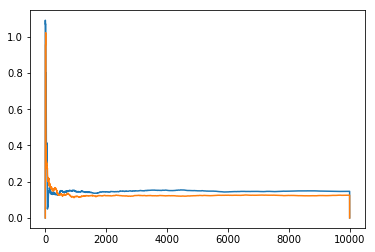

In [485]:
A = np.array([[.65, .35 ], [.1, .9]])  #incorrect guesses
#B = np.array([[.8, .1, .1], [.09, .05, .905]]) #incorrect guesses
#A = np.array([[.9, .1, ], [.2, .8]]) #correct A
B = np.array([[.9, .05, .05], [.05, .05, .9]]) #correct B guess
A_guess, B_guess, xi, alpha, b, a, err, err2 =forward_online(O, A, B, pi)

print(A_guess)
print(B_guess)
plt.plot(err)
plt.plot(err2)